## Audio Classification

In this notebook we are going to train an audio classifier on the [Speech Commands dataset](https://drive.usercontent.google.com/download?id=1J0rGy64nRSNdAjgfDXzPHs_YHkvAiP8-). It is a multi-class classification problem. After running the notebook as it is, you are invited to use the same notebook to train a model on your custom dataset. 

The network of this notebook is a 1-Dimensional CNN, similar to the networks we saw in week 5 for image classification. The specific architecture is modeled after the M5 network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf). You can read more about Speech Command Classification with torchaudio in [PyTorch Tutorial page](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) which is also the reference point for this notebook. This notebook follows the structure of [this reference notebook](https://github.com/terrybroad/CCI-AI-4-Media-23-24/blob/main/Week-6a-Audio-classification/01-train-audio-classifier.ipynb) from Terence Broad.

Possibly needed installs:

In [ ]:
# Librosa is a python package for music and audio analysis that we will use in the other notebook.
# !conda install conda-forge::librosa -y

# I needed to downgrade numpy from 2.2 to 2.1 to make torchaudio work effectively.
# First check the code below to see if it works for you.
# If it doesn't, uncomment the next line and run it.
# !conda install -c conda-forge numpy=2.1

We will start with downloading the training dataset.

You can use the `gdown` module to download the dataset from its google drive link (see below) or you can download the dataset manually from [this link](https://drive.usercontent.google.com/download?id=1J0rGy64nRSNdAjgfDXzPHs_YHkvAiP8-) and move it in the `datasets` folder of this directory.

In [ ]:
# If an error occurs, you might be missing the gdown package
# Install it by running `!pip install gdown` on a seperate cell
!gdown 1J0rGy64nRSNdAjgfDXzPHs_YHkvAiP8-

In [ ]:
# create a path to move your dataset in
import os
PATH = './datasets'
if not os.path.exists(PATH):
    os.makedirs(PATH)

In [ ]:
# Unzip the dataset and move it to the designated directory

# *** for MAC and Linux OS ***
!unzip speech-commands.zip            # unzip dataset
!mv speech-commands ./datasets        # move the unzipped dataset in the designated directory
!rm speech-commands.zip               # remove the zip file from this directory
!rm -rf __MACOSX                      # remove all hidden unnecessary files starting with _MACOSX

# *** for Windows OS ***
# !tar -xf speech-commands.zip               # unzip dataset
# !robocopy speech-commands ./datasets/ /E   # copy and paste unzipped dataset to the designated directory 
# !del speech-commands.zip                   # delete the zip file from this directory
# !rmdir /s /q speech-commands               # delete the entire directory tree without confirmation

#### Imports

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchaudio
import torch

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import numpy as np
import os

from src.audio_dataloader import AudioFolder

# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
# you can skip this step if you created your dataset folder manually
# with your custom classes
# dataset = torchaudio.datasets.SPEECHCOMMANDS('./datasets' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

#### Hyperparameters

In [ ]:
new_sample_rate = 8000
batch_size = 256
learn_rate = 1e-2
weight_decay = 1e-4
num_epochs = 2
val_size = 0.3
# Root directory for dataset
dataroot = './datasets/speech-commands'
# Path to new model
save_path = 'models/model.pt'

#### Metadata of a sample audio file

Below you will notice that:
- The audio is sampled at 16,000 samples per second (16 kHz). This is a common rate for speech processing.

- The total number of frames is also 16,000. Since it's an audio clip sampled at 16 kHz, it will be 1-second long.

- The audio is mono (single-channel).

- Each sample is represented using 16 bits (2 bytes), which is standard for high-quality audio.

- The audio uses PCM (Pulse Code Modulation) Signed encoding, a common uncompressed format where samples are stored as signed integers.

In [ ]:
# Select a sample audio file from the training dataset and look into its metadata
sample_wav = dataroot + '/train/bed/0a7c2a8d_nohash_0.wav' # change to any sample you wish to view
metadata = torchaudio.info(sample_wav)
waveform, sample_rate = torchaudio.load(sample_wav)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
waveform.shape # see (num_channels, num_samples)

torch.Size([1, 16000])

#### Listen to audio with its original sample rate

In [19]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

#### Listen to audio after transformations are applied

Compare the sound of the file before and after downsampling it.

In [13]:
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

transformed = transform(waveform)
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
transformed.shape # see (num_channels, num_samples)

torch.Size([1, 8000])

#### Dataset

In [14]:
dataset = AudioFolder(dataroot, transform=transform)

train_dataset = AudioFolder(dataroot + '/train', transform=transform)
val_dataset = AudioFolder(dataroot + '/test', transform=transform)

print(len(train_dataset), len(train_dataset.classes), train_dataset.classes)
print(len(val_dataset), len(val_dataset.classes), val_dataset.classes)

94824 35 ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
11005 35 ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [ ]:
# code cell from PyTorch Tutorial
# https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
# to make all tensors in a batch of the same length

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # Specifically, pad shorter tensors with zeros to match the length of the longest one.
    # The max length is dynamically determined in each batch based on the longest waveform in that batch.
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1) # the final shape is (batch_size, num_channels, max_length), standard format for audio processing


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [torch.Tensor(waveform)]
        targets += [label]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = np.stack(targets)
    targets = torch.Tensor(targets)
    targets = targets.to(torch.long)

    return tensors, targets

In [ ]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

##### Plot a sample

Data batch shape: torch.Size([256, 1, 8000])
Shape of waveform: torch.Size([8000])
Class of waveform: 'cat'


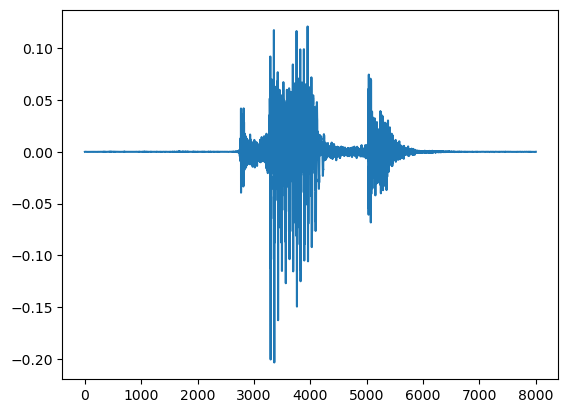

In [27]:
data_batch, label_batch = next(iter(train_loader))
sample_waveform = data_batch[0].squeeze()
print(f'Data batch shape: {data_batch.shape}') # (batch_size, num_channels, max_length)
print(f"Shape of waveform: {sample_waveform.size()}")
sample_class = int(label_batch[0].item())
print(f'Class of waveform: \'{train_dataset.classes[sample_class]}\'')
plt.plot(sample_waveform.t().numpy())

#### Model Architecture

1-Dimensional Convolutional Neural Network to process raw audio data.

In [33]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [34]:
model = M5(n_input=1, n_output=len(train_dataset.classes))
model.to(device)
print(model)

# the number of parameters to be learnt
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n = count_parameters(model)
print("Number of parameters: %s" % n)

# optimiser
optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
# loss function
criterion = nn.CrossEntropyLoss()

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

#### Train Function

In [35]:
def train(model, epoch, log_interval, losses):
    # put model is training mode
    model.train()
    model.to(device)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        # move data into the designated device
        data = data.to(device)
        target = target.to(device)

        # forward pass through the model
        output = model(data)

        # evaluate based on the difference between predicted output and original target
        loss = criterion(output.squeeze(), target)
        # backpropagate loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # to be used for cumulative loss
        train_loss += loss.item()
        
        # update the graphic bar that shows the progress of training per batch
        pbar.update(pbar_update)

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    
    # get cumulative loss for each batch
    train_loss = train_loss / len(train_loader)
    losses.append(train_loss)


#### Validation Function

In [36]:
# evaluation functions
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

# validation function
def val(model, epoch, losses):
    # put model in evaluation mode
    model.eval()
    model.to(device)
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        for data, target in val_loader:
            
            # move data into the designated device
            data = data.to(device)
            target = target.to(device)
            
            # forward pass through the model
            output = model(data)

            # evaluate based on the difference between predicted output and original target
            loss = criterion(output.squeeze(), target)

            # to be used for cumulative loss
            val_loss += loss.item()

            # use evaluation functions defined above
            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)
            
            # update the graphic bar that shows the progress of training per batch
            pbar.update(pbar_update)

        val_loss = val_loss / len(train_loader)
        losses.append(val_loss)

    print(f"\nValidation Epoch: {epoch}\tAccuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n")

#### Training Loop

In [37]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(val_loader))
train_losses = []
val_losses = []
best_loss = 10000

# while tracking the graphic bar of progress
with tqdm(total=num_epochs) as pbar:
    # call the train and val functions for each epoch of training
    for epoch in range(1, num_epochs+1):
        train(model, epoch, log_interval, train_losses)
        val(model, epoch, val_losses)
        # save the model if the last val_loss added is better than the previous one
        # similar to early stopping
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            torch.save(model.cpu().state_dict(), save_path)

  0%|          | 0.0024154589371980675/2 [00:07<1:44:15, 3131.63s/it]

Train Epoch: 1 [0/94824 (0%)]	Loss: 3.726570


  3%|▎         | 0.05314009661835746/2 [00:12<02:45, 85.11s/it]      

Train Epoch: 1 [5120/94824 (5%)]	Loss: 3.092683


  5%|▌         | 0.10144927536231875/2 [00:16<02:37, 83.03s/it] 

Train Epoch: 1 [10240/94824 (11%)]	Loss: 2.648009


  7%|▋         | 0.1497584541062802/2 [00:20<02:23, 77.30s/it] 

Train Epoch: 1 [15360/94824 (16%)]	Loss: 2.282869


 10%|▉         | 0.19565217391304368/2 [00:24<02:32, 84.45s/it]

Train Epoch: 1 [20480/94824 (22%)]	Loss: 2.153264


 12%|█▏        | 0.24637681159420333/2 [00:28<02:18, 78.92s/it]

Train Epoch: 1 [25600/94824 (27%)]	Loss: 2.009328


 15%|█▍        | 0.2946859903381649/2 [00:32<02:10, 76.51s/it] 

Train Epoch: 1 [30720/94824 (32%)]	Loss: 1.845268


 17%|█▋        | 0.34299516908212646/2 [00:35<02:06, 76.35s/it]

Train Epoch: 1 [35840/94824 (38%)]	Loss: 1.668246


 20%|█▉        | 0.39130434782608803/2 [00:39<02:07, 79.18s/it]

Train Epoch: 1 [40960/94824 (43%)]	Loss: 1.447876


 22%|██▏       | 0.4396135265700496/2 [00:43<02:01, 78.02s/it] 

Train Epoch: 1 [46080/94824 (49%)]	Loss: 1.537735


 24%|██▍       | 0.4855072463768131/2 [00:47<01:58, 78.08s/it] 

Train Epoch: 1 [51200/94824 (54%)]	Loss: 1.291737


 27%|██▋       | 0.5362318840579727/2 [00:51<01:54, 78.20s/it] 

Train Epoch: 1 [56320/94824 (59%)]	Loss: 1.446006


 29%|██▉       | 0.5845410628019343/2 [00:55<01:52, 79.66s/it]

Train Epoch: 1 [61440/94824 (65%)]	Loss: 1.114852


 32%|███▏      | 0.6328502415458959/2 [00:59<01:49, 80.41s/it]

Train Epoch: 1 [66560/94824 (70%)]	Loss: 1.350366


 34%|███▍      | 0.6787439613526594/2 [01:02<01:50, 83.45s/it]

Train Epoch: 1 [71680/94824 (75%)]	Loss: 1.150255


 36%|███▋      | 0.7270531400966209/2 [01:07<01:50, 86.81s/it]

Train Epoch: 1 [76800/94824 (81%)]	Loss: 1.269595


 39%|███▉      | 0.7777777777777806/2 [01:11<01:39, 81.30s/it]

Train Epoch: 1 [81920/94824 (86%)]	Loss: 1.009149


 41%|████▏     | 0.8260869565217421/2 [01:15<01:36, 82.28s/it]

Train Epoch: 1 [87040/94824 (92%)]	Loss: 0.937076


 44%|████▎     | 0.8743961352657037/2 [01:19<01:31, 80.99s/it]

Train Epoch: 1 [92160/94824 (97%)]	Loss: 1.189189


 50%|█████     | 1.0000000000000038/2 [01:33<03:18, 198.81s/it]


Validation Epoch: 1	Accuracy: 7111/11005 (65%)



 50%|█████     | 1.0024154589372019/2 [01:33<02:51, 171.71s/it]

Train Epoch: 2 [0/94824 (0%)]	Loss: 0.938602


 53%|█████▎    | 1.0507246376811634/2 [01:37<01:17, 81.21s/it] 

Train Epoch: 2 [5120/94824 (5%)]	Loss: 0.987079


 55%|█████▌    | 1.101449275362323/2 [01:41<01:14, 82.77s/it] 

Train Epoch: 2 [10240/94824 (11%)]	Loss: 1.030398


 57%|█████▋    | 1.1497584541062846/2 [01:45<01:11, 83.68s/it]

Train Epoch: 2 [15360/94824 (16%)]	Loss: 0.994489


 60%|█████▉    | 1.1980676328502462/2 [01:49<01:08, 84.87s/it]

Train Epoch: 2 [20480/94824 (22%)]	Loss: 1.049114


 62%|██████▏   | 1.2439613526570097/2 [01:53<01:07, 89.57s/it]

Train Epoch: 2 [25600/94824 (27%)]	Loss: 1.001571


 65%|██████▍   | 1.2922705314009713/2 [01:58<01:07, 95.04s/it]

Train Epoch: 2 [30720/94824 (32%)]	Loss: 0.926291


 67%|██████▋   | 1.3405797101449328/2 [02:02<01:01, 93.01s/it] 

Train Epoch: 2 [35840/94824 (38%)]	Loss: 1.009166


 69%|██████▉   | 1.3888888888888944/2 [02:07<00:53, 87.20s/it]

Train Epoch: 2 [40960/94824 (43%)]	Loss: 1.021859


 72%|███████▏  | 1.437198067632856/2 [02:11<00:54, 96.72s/it]  

Train Epoch: 2 [46080/94824 (49%)]	Loss: 0.995782


 74%|███████▍  | 1.4879227053140156/2 [02:16<00:44, 87.07s/it] 

Train Epoch: 2 [51200/94824 (54%)]	Loss: 0.863811


 77%|███████▋  | 1.533816425120779/2 [02:20<00:39, 85.41s/it] 

Train Epoch: 2 [56320/94824 (59%)]	Loss: 0.967744


 79%|███████▉  | 1.5821256038647407/2 [02:24<00:36, 87.55s/it]

Train Epoch: 2 [61440/94824 (65%)]	Loss: 0.899881


 82%|████████▏ | 1.6304347826087022/2 [02:28<00:32, 87.17s/it]

Train Epoch: 2 [66560/94824 (70%)]	Loss: 0.745294


 84%|████████▍ | 1.6787439613526638/2 [02:33<00:28, 87.67s/it]

Train Epoch: 2 [71680/94824 (75%)]	Loss: 0.791577


 86%|████████▋ | 1.7270531400966254/2 [02:37<00:23, 85.83s/it]

Train Epoch: 2 [76800/94824 (81%)]	Loss: 0.887895


 89%|████████▉ | 1.775362318840587/2 [02:41<00:19, 88.93s/it] 

Train Epoch: 2 [81920/94824 (86%)]	Loss: 0.807333


 91%|█████████ | 1.8236714975845485/2 [02:45<00:15, 88.25s/it]

Train Epoch: 2 [87040/94824 (92%)]	Loss: 0.853953


 94%|█████████▎| 1.87198067632851/2 [02:50<00:10, 85.60s/it]  

Train Epoch: 2 [92160/94824 (97%)]	Loss: 0.732406


100%|█████████▉| 1.9975845410628101/2 [02:59<00:00, 78.02s/it]/opt/homebrew/Caskroom/miniforge/base/envs/dmlap25my/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 2.000000000000008/2 [03:00<00:00, 90.01s/it] 


Validation Epoch: 2	Accuracy: 8076/11005 (73%)



#### Plot Losses

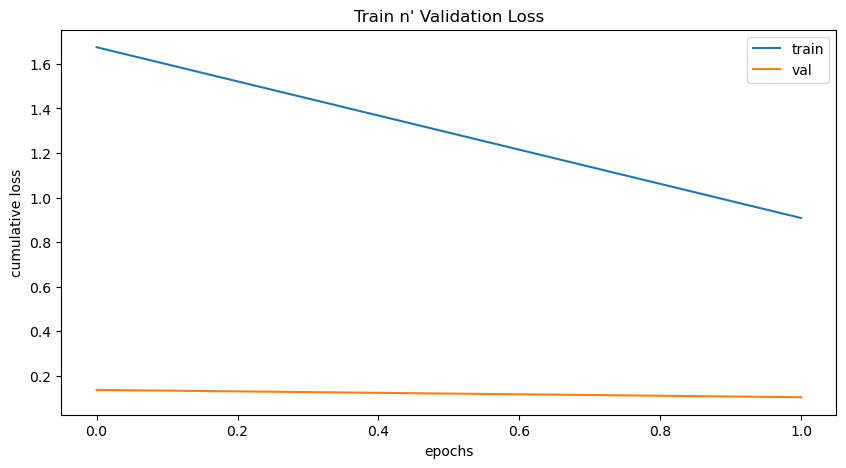

In [38]:
plt.figure(figsize=(10,5))
plt.title("Train n' Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

#### Inference

Test the performance of the model with unseen data from the test subfolder of speech commands.

Use the sound files from the `sounds` folder.

In [39]:
# Load the saved model
state_dict = torch.load('./models/model.pt') # add the path to your saved model, if different

# Instantiate the model and put it in evaluation mode
model = M5(n_input=1, n_output=len(train_dataset.classes))
model.load_state_dict(state_dict)
model.eval()

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [40]:
# Load audio file from your custom path
test_wav = './sounds/test.wav'

# Check if the file exists
if not os.path.exists(test_wav):
    print("Error: Audio file does not exist.")
else:
    # Load the audio file
    waveform, sample_rate = torchaudio.load(test_wav)
    # Check if the duration of the audio is too short
    min_duration = 1.0  # minimum duration in seconds
    print(waveform.size(1))
    if waveform.size(1) / sample_rate < min_duration:
        print("Error: Audio duration is too short.")
    else:
        # proceed with inference
        transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        transformed = transform(waveform)
        # print(transformed.shape)
        input_data = transformed.unsqueeze(0)  # add batch dimension
        # print(input_data.shape)

100352


In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_data)

# Get the predicted label
pred = output.argmax(dim=-1)
pred_label = train_dataset.classes[pred.item()]

print("Predicted label:", pred_label)

Predicted label: yes


In [42]:
# Is it what the model predicted?
ipd.Audio(transformed.numpy(), rate=new_sample_rate)